import sys
sys.path.insert(0,'/Users/alehmann/projects/ecosense-au-dk/omnitrack-common/omnitrack-model/src/main/resources/dk/au/cs/ubi/omnitrack/proto/')
import raw_data_protos_pb2 as protos

In [14]:
#reload(protos)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [15]:
#with open('/Users/anderslehmann/Downloads/protobuf-2.4.1/examples/test','rb') as f:
import os

from math import atan2
from pandas import DataFrame
import datetime

def rad(angle):
    return angle/180*pi

def haversine(*args):
	# a = sin²(Δφ/2) + cos(φ1).cos(φ2).sin²(Δλ/2)
    # c = 2.atan2(√a, √(1−a))
    # d = R.c
    # d er i kilometer?
    R = 6371 #km
    lat, lon, lat1, lon1 = map(rad, args)
    dlat = lat1 - lat
    dlon = lon1 - lon
    a = sin(dlat/2)**2 + cos(lat)*cos(lat1)*sin(dlon/2)**2
    c = 2*atan2(sqrt(a),sqrt(1-a))
    d = R*c
    return d

def varint(buffer):
    i = 0
    res = 0
    ch = ord(buffer.read(1))
    while(ch&0x80):
        res += (ch&0x7f)<<(7*i)
        i += 1
        ch = ord(buffer.read(1))
    res += (ch&0x7f)<<(7*i)
    return res

def read_separated_proto(data_path, proto_cls):

    with open(data_path,'r') as proto_file:
        while True:
            try:
                length = varint(proto_file)
                #print length
            except:
                break
            data = proto_file.read(length)
            proto = proto_cls()
            proto.ParseFromString(data)
            yield proto
            

def reformat_location(point0, point1):
    d = haversine(point0.latitude, point0.longitude, point1.latitude, point1.longitude)
    if d > 0.1: 
        pass
        #print "{} {} {},{},{},{}".format(d,point1.timestamp,point0.latitude, point0.longitude, point1.latitude, point1.longitude)
        #print point1.accuracy, point0.accuracy
    t = point1.timestamp-point0.timestamp
    gps_speed = (point0.speed+point1.speed)/2
    #speed.append(gps_speed)
    if t>0 : 
        cs = 3600*1000*d/t
    else: 
        cs = 0
    timestamp = datetime.datetime.fromtimestamp(point1.timestamp/1000.)
    return (timestamp,t,d,gps_speed,cs,point1.latitude, point1.longitude,point1.accuracy,point1.number_of_satellites)

def get_accuratetime(data_path):
    return read_separated_proto(data_path, protos.AccurateTimeProto).next()


def find_pbuf(path):
    for (spath,dirs,files) in os.walk(path):
        print files
        if 'AccurateTime.pb' in files:
            start = get_accuratetime(spath+'/'+'AccurateTime.pb')
            starttime = start.accurate_time
            startref = start.accurate_time_reference
            print starttime,startref
        else:
            continue

        for f in files:
            fi = spath+'/'+f
            if not f.endswith('.pb'):
                continue
            if 'Accelerometer' in f:
                print fi, '<<<<<<<<<<<<<<<<'

                genaccel = read_separated_proto(fi, protos.AccelerometerEventProto)
                data = DataFrame([(datetime.datetime.fromtimestamp(d.timestamp/1000),d.x,d.y,d.z) for d in genaccel],
                            columns=('time','x','y','z'))
                data = data.sort(columns=('time',))
                data = data.set_index('time')
                yield fi,data
            if 'Gps' in f : 
                genlocation = read_separated_proto(fi, protos.GpsLocationProto)
                #oldlocation = genlocation.next()
                #print oldlocation.timestamp,"<==========="
                lst = []
                data = DataFrame([(datetime.datetime.fromtimestamp(d.timestamp/1000.),d.altitude,d.bearing,d.speed,d.latitude,d.longitude,
                                   d.accuracy,d.number_of_satellites ) for d in genlocation], 
                                 columns=['time','altitude','bearing','speed','Latitude','Longitude',
                                                    'accuracy','satellites'])
                data = data.sort(columns=('time',))
                data = data.set_index('time',)
                yield fi,data

data_path = '/Users/alehmann/projects/DataMarkus2014/data/data/'#2013/2013-12-04-car-automatic-matthias/first-trip/it120-left-trouser-pocket/' #2013-12-04T10.23.18+01.00/AccurateTime.pb'
    
data_array = dict(find_pbuf(data_path))
print len(data_array)

0


In [16]:
def haver_path_length(df):
    longi = df['Longitude']
    lati = df['Latitude']
    deltaD = map(haversine,lati[1:],longi[1:],lati[:-1],longi[:-1])
    deltaD.append(0.)
    ser = pandas.Series(deltaD,index=gps.index)
    df['path_length'] = ser

    

In [17]:
import numpy.ma as ma
ma.masked

masked

In [18]:
import pandas
from pandas import rolling_mean,rolling_median


gps = data_array['/Users/alehmann/projects/DataMarkus2014/data/data/2013/insero-kmh/it139-zoe-ah71951/dk.au.cs.ecosense.continuous/files/2013-10-31/GpsLocation.pb']
#gps = data_array['/Users/alehmann/projects/DataMarkus2014/data/data/2013/2013-11-19-henrik-ff-car/it137-trouser-pocket/2013-11-20T13.08.40+01.00/GpsLocation.pb']
#deltaT = gps['time'][1:]-gps['time'][:-1]
#print data_array.keys()#[1]
gps['tvalue'] = gps.index

gps['deltaT'] =  (gps['tvalue']-gps['tvalue'].shift()).fillna(0.)

urban_limit = 50. #km/h
highway_limit = 95. #km/h

#smooth = lambda x: x
smooth = lambda x: rolling_median(x,10)

haver_path_length(gps)
#gps['speed'].plot()
gps['calc_speed'] = gps['path_length']/smooth(gps['deltaT'])

speed = gps['speed']*3.6

dist = smooth(gps['path_length'])*1000

dist.plot()

figure()
urban_idx = (speed<=(urban_limit))# &(speed>0)
rural_idx = ((urban_limit) < speed)&(speed <=(highway_limit))
highway_idx =(highway_limit) < speed

urban_co2 = dist[urban_idx].sum() 
rural_co2 = dist[rural_idx].sum()
highway_co2 = dist[highway_idx].sum()
print 'CO2_u',urban_co2,'CO2_r',rural_co2,'CO2_h',highway_co2
s=datetime.datetime(2013,10,31,11,52,0); e=datetime.datetime(2013,10,31,12,12,0)

#dist[s:e].plot()
urban = speed[urban_idx]
rural = speed[rural_idx]
highway = speed[highway_idx]

urban = urban.reindex(speed.index)
rural = rural.reindex(speed.index)
highway = highway.reindex(speed.index)

urban.plot()
rural.plot()
if not highway.empty: highway.plot()
ylabel('Speed (km/h)')
legend(('urban','rural','highway'))

savefig('speed_division.eps')
figure()

ylabel('Speed (km/h)')
urban[s:e].plot()
rural[s:e].plot()

#smooth(1000*gps['calc_speed'])[s:e].plot()
if not highway.empty: highway[s:e].plot()
legend(('urban','rural','highway'))
savefig('speed_division_zoom.eps')
#legend()
#speed.plot()
#(0*gps['accuracy']/10)[s:e].plot()
print len(speed),len(urban),len(rural),len(highway)
print speed.index[-1]-speed.index[0],speed.mean()*3.6,dist.sum()/(speed.index[-1]-speed.index[0]).total_seconds()*3600
idx_t = dist.index
dt = idx_t[1:]#-idx_t[:-1]
print dt
#holes = dt[dt>10]

KeyError: '/Users/alehmann/projects/DataMarkus2014/data/data/2013/insero-kmh/it139-zoe-ah71951/dk.au.cs.ecosense.continuous/files/2013-10-31/GpsLocation.pb'

time
2013-10-31 08:22:39.247000    21.482986
2013-10-31 08:22:40.248000    18.532954
2013-10-31 08:22:41.248000    18.267286
2013-10-31 08:22:42.252000    18.050768
2013-10-31 08:22:43.845000    18.253236
2013-10-31 08:22:44.259000    18.194467
2013-10-31 08:22:45.256000    18.725147
2013-10-31 08:22:46.249000    18.631874
2013-10-31 08:22:47.256000    18.141150
2013-10-31 08:22:48.249000    18.229979
2013-10-31 08:22:49.247000    18.547859
2013-10-31 08:22:50.249000    16.933399
2013-10-31 08:22:51.257000    17.078286
2013-10-31 08:22:52.250000    16.733090
2013-10-31 08:22:53.256000    17.252726
...
2013-10-31 22:58:41.235000    19.139963
2013-10-31 22:58:42.234000    18.547415
2013-10-31 22:58:43.232000    18.214225
2013-10-31 22:58:44.232000    18.050081
2013-10-31 22:58:45.235000    17.897668
2013-10-31 22:58:46.232000    17.410849
2013-10-31 22:58:47.237000    17.587922
2013-10-31 22:58:48.249000    16.918916
2013-10-31 22:58:49.282000    16.438547
2013-10-31 22:58:50.238000    1

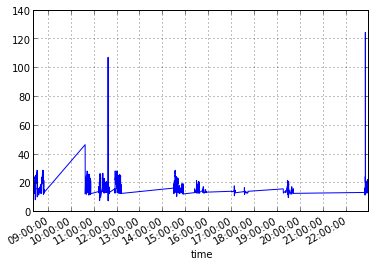

In [9]:
dist2 = gps['path_length']*1000
rural_co2 = dist2[rural_idx]
print rural_co2,rural_co2.sum(),rural_co2.mean(),rural_co2.max()
rural_co2.plot()

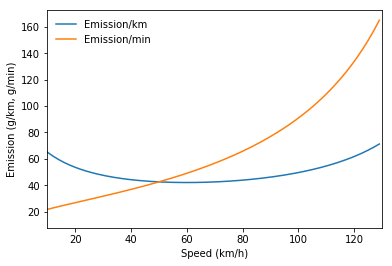

In [13]:
#Hot emission formula(Gasoline post EURO 1): EF = (a + c ￼ V + e ￼ V2)/(1 + b ￼ V + d ￼ V2)
# 
a,b,c,d,e = 1.91E+02,1.29E-01,1.17E+00,-7.23E-04,0 #FC EURO 1 <1.4

def EF(V): 
    """ Calculates the speed dependency of hot emission g/km"""
    res = (a+V*c+(V**2)*e)/(1.+V*b+(V**2)*d)
    return res

v = arange(10,140)
ylabel('Emission (g/km, g/min)')
xlabel('Speed (km/h)')
xlim(10,130)
plot(EF(v),label='Emission/km')
plot(EF(v)*v/60, label='Emission/min') #Emission in g/km*km/h/(60 min) = g/min
legend()
savefig('emission_vs_speed.eps')

22.23092925 6.98351524057


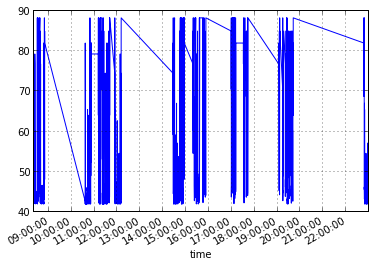

In [32]:
smo = smooth(speed)
FC = EF(speed[speed>2.778]*3.6)# g/km
FC.plot()#style='bo')
FC_calc= FC*(dist)/1000 # g
r_hc=1.80
r_oc=0.0
E = 44.011*sum(FC_calc)/(12.011+1.008*r_hc+16.*r_oc)
print E/1000,sum(FC_calc)/1000 # kg

In [33]:
#Hot emision factor (Diesel post euro 1) EF = (a + c V + e V2)/(1 + b V + d V2) + f/V

def EF_d(V):
    res = EF(V) + f/V

In [34]:
idx = dist[dist>1000]
l = dist>1000
print haversine(55.931207,12.349773,55.911115,12.266167),gps
gps[dist.argmax()-datetime.timedelta(seconds=10):]
#dist[date_range([2013,10,31,9,48])]
dr =pandas.date_range(dist.index[0],dist.index[-1],freq='s')
dist1 = dist.reindex(dr)
dist1[dist1.argmax()-datetime.timedelta(seconds=10):]


5.66805083239                               altitude     bearing     speed   Latitude  \
time                                                                      
2013-10-31 07:24:55.514000   62.799999    0.000000  0.000000  55.931366   
2013-10-31 07:24:56.490000   97.099998  132.899994  1.500000  55.931361   
2013-10-31 07:24:57.449000   97.599998   68.500000  1.677051  55.931373   
2013-10-31 07:24:58.507000  106.500000   68.500000  0.707107  55.931393   
2013-10-31 07:24:59.514000  144.300003   68.500000  0.250000  55.931392   
2013-10-31 07:25:16.581000  132.899994    0.000000  0.000000  55.931398   
2013-10-31 07:32:56.285000  152.500000    0.000000  0.000000  55.931416   
2013-10-31 07:32:57.287000  152.100006    0.000000  0.000000  55.931416   
2013-10-31 07:32:58.241000  152.100006    0.000000  0.000000  55.931416   
2013-10-31 07:32:59.207000  151.600006    0.000000  0.000000  55.931417   
2013-10-31 07:33:00.251000  151.500000    0.000000  0.000000  55.931417   
2013-10-31 

2013-10-31 08:43:44.514000          NaN
2013-10-31 08:43:45.514000          NaN
2013-10-31 08:43:46.514000          NaN
2013-10-31 08:43:47.514000          NaN
2013-10-31 08:43:48.514000          NaN
2013-10-31 08:43:49.514000          NaN
2013-10-31 08:43:50.514000          NaN
2013-10-31 08:43:51.514000          NaN
2013-10-31 08:43:52.514000          NaN
2013-10-31 08:43:53.514000          NaN
2013-10-31 08:43:54.514000    27.454779
2013-10-31 08:43:55.514000          NaN
2013-10-31 08:43:56.514000          NaN
2013-10-31 08:43:57.514000          NaN
2013-10-31 08:43:58.514000          NaN
...
2013-10-31 23:43:09.514000   NaN
2013-10-31 23:43:10.514000   NaN
2013-10-31 23:43:11.514000   NaN
2013-10-31 23:43:12.514000   NaN
2013-10-31 23:43:13.514000   NaN
2013-10-31 23:43:14.514000   NaN
2013-10-31 23:43:15.514000   NaN
2013-10-31 23:43:16.514000   NaN
2013-10-31 23:43:17.514000   NaN
2013-10-31 23:43:18.514000   NaN
2013-10-31 23:43:19.514000   NaN
2013-10-31 23:43:20.514000   NaN


In [35]:
d=datetime.datetime.now()
print d.date()


2014-06-18


In [36]:
            
def get_accuratetime(data_path):
    return read_separated_proto(data_path, protos.AccurateTimeProto).next()
data_path = '/Users/alehmann/projects/DataMarkus2014/data/data/2013/2013-12-04-car-automatic-matthias/first-trip/it120-left-trouser-pocket/2013-12-04T10.23.18+01.00/GpsLocation.pb'
start = get_accuratetime(data_path)
print start.accurate_time, start.accurate_time_reference
import datetime,time
print int(time.time()*1000)
print datetime.datetime.now()
print datetime.datetime.fromtimestamp(start.accurate_time/1000.) #.strftime("%d %m% %Y")

1386149020754 0
1403113526724
2014-06-18 19:45:26.724394
2013-12-04 10:23:40.754000


In [37]:
fishy_path ='/Users/alehmann/projects/DataMarkus2014/data/data/2013/2013-08-29to31-henrik-bike/it146/2013-08-29T17.05.53.913/'
genlocation = find_pbuf(fishy_path)
data_map = {}
for fi,data in genlocation:
    data_map[fi] = data

['AccelerometerEvent.pb', 'AccurateTime.pb', 'BatteryLevelEvent.pb', 'DeviceInfo.pb', 'GpsLocation.pb', 'groundtruth.txt', 'GsmCellLocation.pb', 'NetworkLocation.pb', 'ScreenEvent.pb', 'ServiceState.pb', 'SignalStrength.pb', 'WifiScanResults.pb']
1377790712002 110616259
/Users/alehmann/projects/DataMarkus2014/data/data/2013/2013-08-29to31-henrik-bike/it146/2013-08-29T17.05.53.913//AccelerometerEvent.pb <<<<<<<<<<<<<<<<


In [38]:
data_map['/Users/alehmann/projects/DataMarkus2014/data/data/2013/2013-08-29to31-henrik-bike/it146/2013-08-29T17.05.53.913//GpsLocation.pb']

,altitude,bearing,speed,Latitude,Longitude,accuracy,satellites
time,,,,,,,
2013-08-29 17:46:00.012000,306.299988,0.000000,0.000000,56.171070,10.187805,161,2
2013-08-29 17:46:00.220000,306.299988,0.000000,0.000000,56.171070,10.187805,161,2
2013-08-29 17:46:00.973000,366.799988,0.000000,0.000000,56.170308,10.186939,227,2
2013-08-29 17:46:01.174000,366.799988,0.000000,0.000000,56.170308,10.186939,227,2
2013-08-29 17:46:20.036000,159.399994,0.000000,0.000000,56.171986,10.188961,99,5
2013-08-29 17:46:20.226000,159.399994,0.000000,0.000000,56.171986,10.188961,99,5
2013-08-29 17:46:43.079000,155.899994,63.400002,2.015564,56.171947,10.189079,36,6
2013-08-29 17:46:43.204000,155.899994,63.400002,2.015564,56.171947,10.189079,36,6
2013-08-29 17:46:44.059000,134.899994,12.700000,1.500000,56.171949,10.189027,29,6


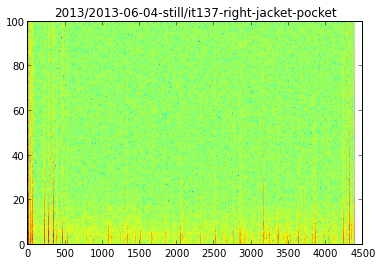

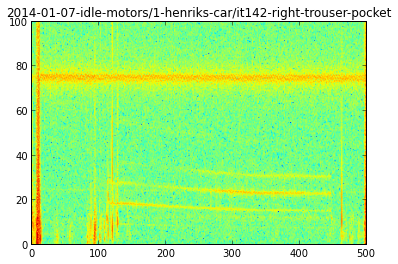

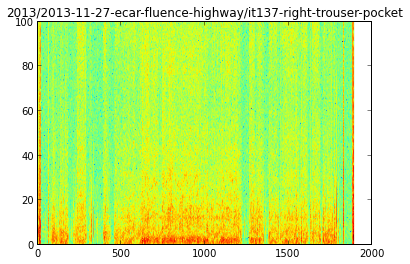

In [ ]:
NFFT = 8192/16
Fs = 1/0.005
import matplotlib.mlab as mlab
from scipy import signal
from pandas import rolling_mean
import scikits.audiolab
import os.path as p

start = 0
end = -1
b,a = signal.butter(5, 30. / (Fs/2.), btype='high')
b1,a1 = signal.butter(5, 80. / (Fs/2.), btype='low')

for fi,acc in data_array.items():
    try:
        if not 'Accel' in fi:
            continue
        #if not 'idle-motors' in fi:
        #if not 'matthias' in fi:
        #if not 'it142' in fi: #It seems that IT142 is broken - though it worked in 2013
        #    continue
        """fig = pyplot.figure()
        pyplot.title( '/'.join(fi.split('/')[-5:-2]))    
        sp=fig.add_subplot(211)
        x = acc['x'][start:end]
        rolling_mean(x,120).plot()
        y = acc['y'][start:end]
        rolling_mean(y,120).plot()
        z = acc['z'][start:end]
        rolling_mean(z,120).plot()
"""
        g = sqrt(acc['x'].mul(acc['x'])+acc['y'].mul(acc['y'])+acc['z'].mul(acc['z']))
       # g = signal.lfilter(b,a,g)
       # g = signal.lfilter(b1,a1,g)
        #sp=fig.add_subplot(212)
        if 0:
            name = '/Users/alehmann/projects/soundfiles/%s.wav'%'_'.join(fi.split('/')[-5:-2])
            if not os.path.isfile(name):
                print name
            
            snd = g-g.mean()
            scikits.audiolab.wavwrite(snd.values, name, fs=1000, enc='pcm16')
        fig = pyplot.figure()
        pyplot.title( '/'.join(fi.split('/')[-5:-2]))    
            
        Pxx, freqs, bins, im = specgram(g,NFFT=NFFT,Fs=Fs,noverlap=NFFT/2,
                                           detrend=detrend_mean,scale_by_freq=True)

    #sp.set_yscale('log')
        show()
    except TypeError:
        continue

In [8]:
print len(data_array.keys())

402


In [66]:


def read_onlinedata(filename):
    with open(filename,'r') as f:
        names = 'start'
        names_dict = {}
        while names:
            names = f.next().decode('ISO-8859-1').strip().split()

            if names : names_dict[names[0]] = u' '.join(names[1:])
        

        head = f.next().strip().split(';')
        header = [names_dict[h.strip()] for h in head[1:-1]]
        header.insert(0,head[0].strip())
        res = []
        for row in f:
            data = row.strip().split(';')
#            print data[0]
            try:
                date = datetime.datetime.strptime(data[0].strip(),'%Y-%m-%d %H:%M')
            except ValueError:
                break
            #print data,len(data),len(header),header
            d = [data[0]]+[int(r) for r in data[1:-1]]
            res.append( dict(zip(header,d)))
    return res
res = read_onlinedata('/Users/alehmann/Documents/EnergiNetDK_Data/20110109_onlinedata.txt')
res[0]

{u'Centrale kraftv\xe6rker DK1': 1008,
 u'Centrale kraftv\xe6rker DK2': 1100,
 'Dato og tid': '2011-01-09 00:00 ',
 u'Decentrale kraftv\xe6rker DK1': 662,
 u'Decentrale kraftv\xe6rker DK2': 379,
 u'Temperatur i Tange': 4,
 u'Udveksling Bornholm-Sverige': -3,
 u'Udveksling Fyn-Sjaelland': -122,
 u'Udveksling Jylland-Norge': -950,
 u'Udveksling Jylland-Sverige': -243,
 u'Udveksling Jylland-Tyskland': -160,
 u'Udveksling Sj\xe6lland-Sverige': -515,
 u'Udveksling Sj\xe6lland-Tyskland': 0,
 u'Vindhastighed i Tange': 3,
 u'Vindm\xf8ller DK1': 1858,
 u'Vindm\xf8ller DK2': 524}

In [52]:
import rethinkdb as r
conn = r.connect(db='energinetdk')

In [53]:
r.db_create('Onlinedata').run(conn)

{u'created': 1}

In [54]:
r.db('Onlinedata').table_create('productiondata').run(conn)

{u'created': 1}

In [55]:
data = r.db('Onlinedata').table('productiondata')

In [68]:
import os,time
path = '/Users/alehmann/Documents/EnergiNetDK_Data/'
for d in os.listdir(path):

    start = time.time()
    result = read_onlinedata(path+d)
    read_and_parse = time.time()
    data.insert(result).run(conn)
    insert_t = time.time()
#    print f, "Read and parse : {}; Insert : {}".format(read_and_parse-start,insert_t-read_and_parse)
print 'ok'#data.count()

IOError: [Errno 21] Is a directory: '/Users/alehmann/Documents/EnergiNetDK_Data/spotpriser'

In [ ]:
import pymongo
client = pymongo.MongoClient()
db = client.energinetDK
data = db.productiondata

In [ ]:
curs = data.find({'Dato og tid':datetime.datetime(2012,12,9,0)})#},{'Dato og tid':{'$lt':datetime.datetime(2009,12,10,0,0)}}]})

In [ ]:
#print curs.count()
for c in curs:
    print c

In [ ]:
curs = data.find({'CO2 udledning':{'$exists':True}},{"CO2 udledning":1}).sort([('CO2 udledning',1),])
print curs.count()
#curs.sort({'Dato og tid':1})
co2 = [c['CO2 udledning'] for c in curs]
print max(co2),min(co2)

In [ ]:
curs = data.find({'CO2 udledning':7479})
curs.count()
curs.next()

In [ ]:
arr=array(co2)

In [ ]:
from scipy import histogram
#help(histogram)
a, edges = histogram(arr,bins=range(65,700,3))
print a.shape,edges
plot(array(linspace(65,700,a.shape[0])),a)

In [ ]:
curs = data.find({'CO2 udledning':{'$exists':True}},{"Dato og tid":1,"CO2 udledning":1})

In [ ]:
d = DataFrame([(c["Dato og tid"],c["CO2 udledning"]) for c in curs],columns=["Dato","CO2"])

In [ ]:
d.set_index("Dato")
#d["CO2"].plot(ylim=(25,700))
d2 = DataFrame(d["CO2"].values,index=d["Dato"],columns=["CO2"])

In [ ]:
d2["CO2"].plot(ylim=(25,700))

In [ ]:
curs = data.find({'Vindhastighed i Tange':{'$exists':True}})

In [ ]:
curs.count()

In [ ]:
curs = data.find({'Vindhastighed i Malling':{'$exists':True}})
curs.count()

In [ ]:
curs = data.find()
curs.count()

In [ ]:
185581+181998

In [25]:
a="""1,Anthraquinone Blue,2505,26,21,46,1114
2,Burnt Sienna,2520,102,48,31,1210
3,Burnt Umber,2530,55,43,36,1246
4,Carbon Black,2540,24,25,21,1126
5,Cerulean Blue Chromium,2550,7,66,158,1306
6,Chromium Oxide Green,2560,48,90,45,1342
7,Cobalt Blue,2640,21,30,168,1258
8,Dyarylide Yellow,2647,253,147,10,1126
9,Dioxazine Purple,2650,29,24,51,1102
10,Green Gold,2670,88,94,42,1138
11,Hansa Yellow Opaque,2691,254,206,10,1138
12,Jenkins Green,2695,12,26,0,1150
13,Naphthol Red Medium,2720,139,30,41,1138
14,Paynes Grey,2740,33,37,57,1246
15,Permanent Green Light,2750,13,102,49,1150
16,Phthalo Blue G.S.,2755,2,34,104,1114
17,Phthalo Green B.S.,2770,2,31,37,1126
18,Pyrrole Red,2777,179,36,44,1138
19,Quinacridone Crimson,2790,90,19,37,1102
20,Quinacridone Magenta,2805,108,26,69,1114
21,Raw Sienna,2840,149,101,54,1210
22,Raw Umber,2850,57,51,47,1234
23,Red Oxide,2860,124,52,44,1186
24,Titan Buff,2870,216,203,172,1294
25,Titanium White,2880,254,254,254,1438
26,Ultramarine Blue,2900,21,13,105,1258
27,Yellow Ochre,2907,167,121,44,1258
"""
a.split('\n')

['1,Anthraquinone Blue,2505,26,21,46,1114',
 '2,Burnt Sienna,2520,102,48,31,1210',
 '3,Burnt Umber,2530,55,43,36,1246',
 '4,Carbon Black,2540,24,25,21,1126',
 '5,Cerulean Blue Chromium,2550,7,66,158,1306',
 '6,Chromium Oxide Green,2560,48,90,45,1342',
 '7,Cobalt Blue,2640,21,30,168,1258',
 '8,Dyarylide Yellow,2647,253,147,10,1126',
 '9,Dioxazine Purple,2650,29,24,51,1102',
 '10,Green Gold,2670,88,94,42,1138',
 '11,Hansa Yellow Opaque,2691,254,206,10,1138',
 '12,Jenkins Green,2695,12,26,0,1150',
 '13,Naphthol Red Medium,2720,139,30,41,1138',
 '14,Paynes Grey,2740,33,37,57,1246',
 '15,Permanent Green Light,2750,13,102,49,1150',
 '16,Phthalo Blue G.S.,2755,2,34,104,1114',
 '17,Phthalo Green B.S.,2770,2,31,37,1126',
 '18,Pyrrole Red,2777,179,36,44,1138',
 '19,Quinacridone Crimson,2790,90,19,37,1102',
 '20,Quinacridone Magenta,2805,108,26,69,1114',
 '21,Raw Sienna,2840,149,101,54,1210',
 '22,Raw Umber,2850,57,51,47,1234',
 '23,Red Oxide,2860,124,52,44,1186',
 '24,Titan Buff,2870,216,203,172

In [29]:
lines = a.split('\n')
d = [(line.split(',')[2],line.split(',')[1],int(line.split(',')[-1]),tuple(int(x) for x in line.split(',')[3:6])) for line in lines[:-1]]
d

[('2505', 'Anthraquinone Blue', 1114, (26, 21, 46)),
 ('2520', 'Burnt Sienna', 1210, (102, 48, 31)),
 ('2530', 'Burnt Umber', 1246, (55, 43, 36)),
 ('2540', 'Carbon Black', 1126, (24, 25, 21)),
 ('2550', 'Cerulean Blue Chromium', 1306, (7, 66, 158)),
 ('2560', 'Chromium Oxide Green', 1342, (48, 90, 45)),
 ('2640', 'Cobalt Blue', 1258, (21, 30, 168)),
 ('2647', 'Dyarylide Yellow', 1126, (253, 147, 10)),
 ('2650', 'Dioxazine Purple', 1102, (29, 24, 51)),
 ('2670', 'Green Gold', 1138, (88, 94, 42)),
 ('2691', 'Hansa Yellow Opaque', 1138, (254, 206, 10)),
 ('2695', 'Jenkins Green', 1150, (12, 26, 0)),
 ('2720', 'Naphthol Red Medium', 1138, (139, 30, 41)),
 ('2740', 'Paynes Grey', 1246, (33, 37, 57)),
 ('2750', 'Permanent Green Light', 1150, (13, 102, 49)),
 ('2755', 'Phthalo Blue G.S.', 1114, (2, 34, 104)),
 ('2770', 'Phthalo Green B.S.', 1126, (2, 31, 37)),
 ('2777', 'Pyrrole Red', 1138, (179, 36, 44)),
 ('2790', 'Quinacridone Crimson', 1102, (90, 19, 37)),
 ('2805', 'Quinacridone Magenta

In [ ]:
lines.